In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [3]:
# LEITURA E LIMPEZA INICIAL

df_train = pd.read_csv("docs/treino.csv")
df_test = pd.read_csv("docs/teste.csv")

In [4]:
def preparar_dados(df):
    df = df.drop_duplicates()
    df = df.dropna()
    df['latitude'] = df['latitude'].astype(str).str.replace(',', '.').astype(float)
    df['longitude'] = df['longitude'].astype(str).str.replace(',', '.').astype(float)
    colunas_categoricas = ['fase_operacao', 'cat_aeronave', 'regiao', 'uf', 'modelo_aeronave', 'nome_fabricante']
    for col in colunas_categoricas:
        df[col] = LabelEncoder().fit_transform(df[col])
    return df

In [5]:
df_train = preparar_dados(df_train)
df_test = preparar_dados(df_test)

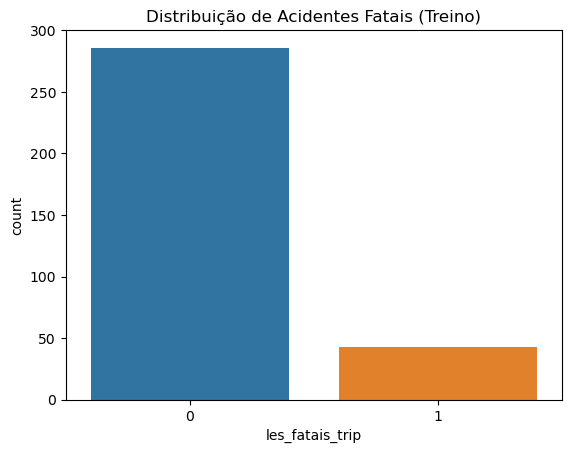

In [6]:
# ANÁLISE EXPLORATÓRIA
sns.countplot(x='les_fatais_trip', data=df_train)
plt.title("Distribuição de Acidentes Fatais (Treino)")
plt.show()

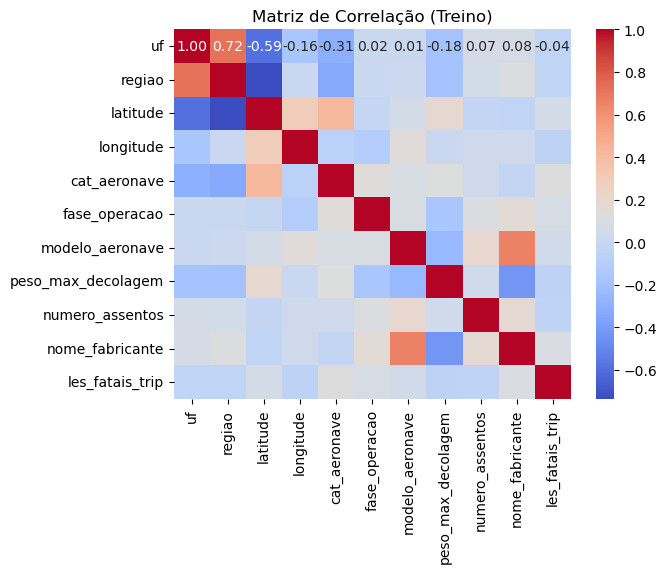

In [7]:
df_numerico = df_train.select_dtypes(include=['int64', 'float64'])
sns.heatmap(df_numerico.corr(), cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Matriz de Correlação (Treino)")
plt.show()

In [8]:
# TREINAMENTO E AVALIAÇÃO DE MODELOS
X_train = df_train[['latitude', 'longitude', 'peso_max_decolagem', 'numero_assentos',
                    'fase_operacao', 'cat_aeronave', 'regiao', 'uf']]
y_train = df_train['les_fatais_trip']

X_test = df_test[['latitude', 'longitude', 'peso_max_decolagem', 'numero_assentos',
                  'fase_operacao', 'cat_aeronave', 'regiao', 'uf']]
y_test = df_test['les_fatais_trip']


In [10]:

modelos = {
    "Árvore de Decisão": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Regressão Logística": LogisticRegression(max_iter=1000)
}

resultados = []
for nome, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    resultados.append([nome,
                       accuracy_score(y_test, y_pred),
                       precision_score(y_test, y_pred),
                       recall_score(y_test, y_pred),
                       f1_score(y_test, y_pred)])

/home/gabrielduarte/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gabrielduarte/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
df_resultados = pd.DataFrame(resultados, columns=["Modelo", "Acurácia", "Precisão", "Recall", "F1-Score"])
print(df_resultados)

                Modelo  Acurácia  Precisão    Recall  F1-Score
0    Árvore de Decisão  0.612903      0.25  0.045455  0.076923
1        Random Forest  0.645161      0.00  0.000000  0.000000
2  Regressão Logística  0.645161      0.00  0.000000  0.000000


In [12]:
melhor_modelo = df_resultados.loc[df_resultados['F1-Score'].idxmax()]
print("\nMelhor modelo:")
print(melhor_modelo)


Melhor modelo:
Modelo      Árvore de Decisão
Acurácia             0.612903
Precisão                 0.25
Recall               0.045455
F1-Score             0.076923
Name: 0, dtype: object


In [13]:
# IMPORTÂNCIA DAS FEATURES E MATRIZ DE CONFUSÃO
modelo_final = RandomForestClassifier(random_state=42)
modelo_final.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

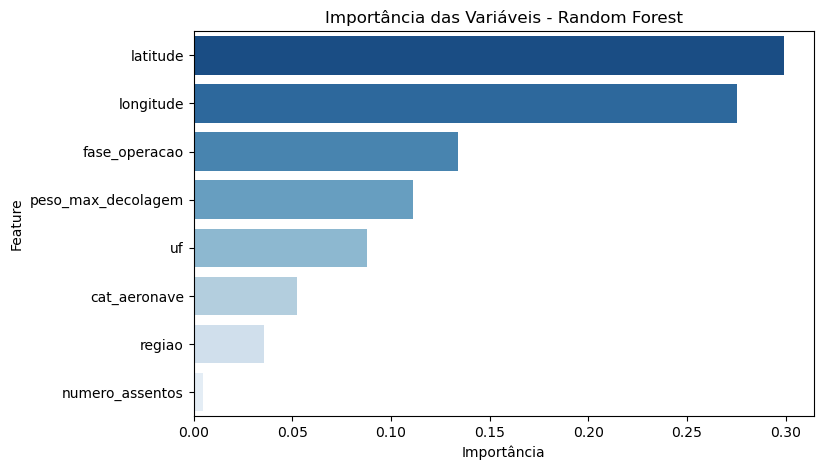

In [14]:
importancias = pd.DataFrame({
    'Feature': X_train.columns,
    'Importância': modelo_final.feature_importances_
}).sort_values(by='Importância', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x='Importância', y='Feature', data=importancias, palette="Blues_r")
plt.title("Importância das Variáveis - Random Forest")
plt.show()

In [15]:
y_pred_final = modelo_final.predict(X_test)
print("Acurácia Final:", accuracy_score(y_test, y_pred_final))
print("Precisão Final:", precision_score(y_test, y_pred_final))
print("Recall Final:", recall_score(y_test, y_pred_final))
print("F1 Score Final:", f1_score(y_test, y_pred_final))


Acurácia Final: 0.6451612903225806
Precisão Final: 0.0
Recall Final: 0.0
F1 Score Final: 0.0


/home/gabrielduarte/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


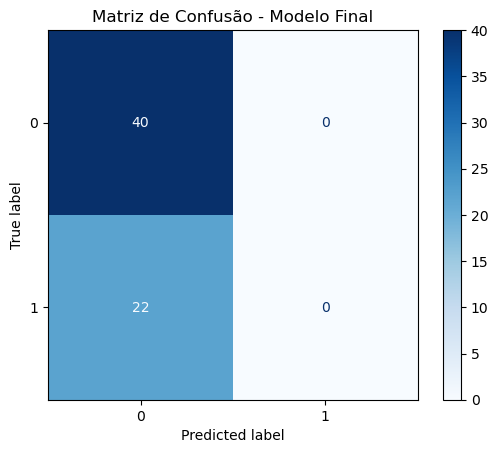

In [16]:
cm = confusion_matrix(y_test, y_pred_final)
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title("Matriz de Confusão - Modelo Final")
plt.show()